# <center><FONT COLOR=pINK> MERCARI PRICE PREDICTION CHALLENGE </FONT></center>

## Table of contents:

[1. **Introduction**](#Intro)

[2. **Exploratory Data Analysis**](#eda)
 

# <FONT COLOR = blue> 1.Introduction </FONT><a id='Intro'></a>

**The goal is to predict the price Target variable for an online retailer Mercari by using the product’s features such as brand, quality etc.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline

seed = 101

#  <FONT COLOR = blue> 1.Exploratory Data Analysis </FONT><a id='eda'></a>
## Features:
   - There are 7 columns present in the dataset (excluding the train_id) 

###  1. Numerical/Continuous Features:

  - __price__: The item's final price. This will be our reponse / independent variable that we need to predict

###  2. Categorical Features:

   - __shipping cost__: A binary indicator, 1 if shipping fee is paid by seller and 0 if it's paid by buyer
   - __item_condition_id__: The condition of the items provided by the seller
   - __name__: The item's name
   - __brand_name__: The item's producer brand name
   - __category_name__: The item's single or multiple categories that are separated by ""
   - __item_description__: A short description on the item.

###   3. Price Distribution:
   - __price__: Price is the target variable

### 4.Item Category Analysis:

- Here category is analysed to see
        1. which  is the hottest category
        2. what are the main categories

In [2]:
# loading the dataset

df_train = pd.read_csv('train_.tsv', sep='\t')
df_test = pd.read_csv('test_.tsv', sep='\t')


In [3]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
df_train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [5]:
print('Train shape:{}\nTest shape:{}'.format(df_train.shape, df_test.shape))

Train shape:(1482535, 8)
Test shape:(693359, 7)


## Dealing Missing data:-

In [6]:
#Checking for the Null dataset

def check_null(data):
    null_col_list=[]
    for col in data:
        if data[col].isnull().sum() >0:
            null_col_list.append(col)
        else:
            pass
    return null_col_list

null_col_list=check_null(df_train)
print("Columns with Null Values = {0}".format(null_col_list))
null_col_list=check_null(df_test)
print("Columns with Null Values = {0}".format(null_col_list))


Columns with Null Values = ['category_name', 'brand_name', 'item_description']
Columns with Null Values = ['category_name', 'brand_name']


In [7]:
df_train['item_description'].fillna(value="No description yet", inplace=True)
#Filling the "item_description" with "No description yet" Like the originial dataset

In [8]:
frac1 = 100 * df_train[df_train['price'] <= 0].shape[0] / df_train.shape[0]
print('%0.2f%% percent of product have 0 price. We may need drop them when we train our model.' % frac1)


0.06% percent of product have 0 price. We may need drop them when we train our model.


In [9]:
zero_price = df_train[df_train['price'] == 0]

In [10]:
zero_price.shape

(874, 8)

In [11]:
#removing the zero price items, which we may not consider.
df_train = df_train[df_train['price'] > 0]
df_train.shape

(1481661, 8)

 ####   '__category_name__', '__brand_name__', '__item_description__' columns are having null values in training data.

###  Item Category Analysis:

In [12]:
# Unique category List
print("There are %d unique values in the category column." % df_train['category_name'].nunique())

There are 1287 unique values in the category column.


In [13]:
## top 10 categories:
df_train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 60152
Women/Tops & Blouses/T-Shirts                                  46349
Beauty/Makeup/Face                                             34320
Beauty/Makeup/Lips                                             29901
Electronics/Video Games & Consoles/Games                       26547
Beauty/Makeup/Eyes                                             25200
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24668
Women/Underwear/Bras                                           21254
Women/Tops & Blouses/Tank, Cami                                20270
Women/Tops & Blouses/Blouse                                    20269
Name: category_name, dtype: int64

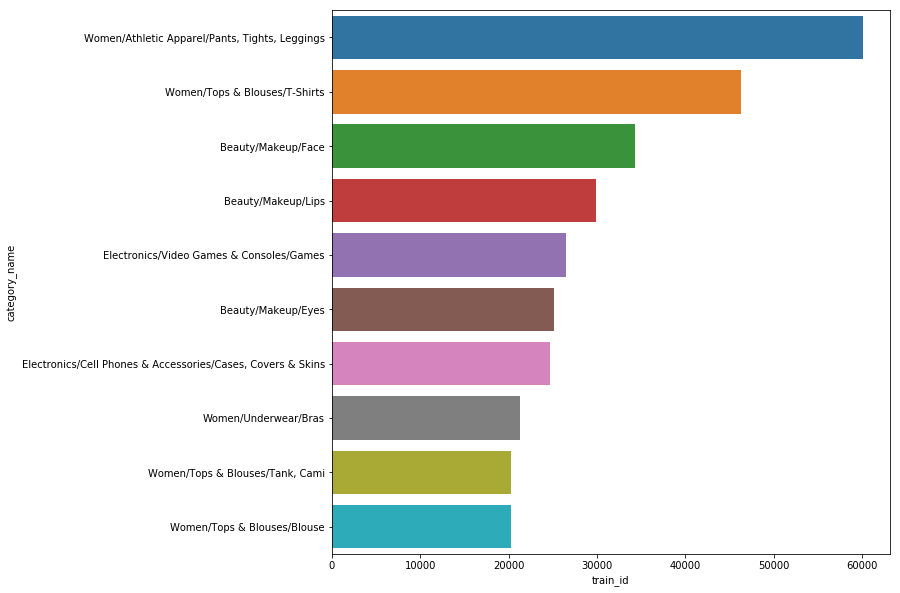

In [14]:
f,ax = plt.subplots(1,1,figsize=(10,10))
hist = df_train.groupby(['category_name'],as_index=False).count().sort_values(by='train_id',ascending=False)[0:10]
sns.barplot(y=hist['category_name'],x=hist['train_id'])
plt.show()

 <center> From the above plot we could  observe that women apparels are most sold in the Mercari app</center>

In [15]:
# Splitting the categories:

def cat_split(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
    
df_train['general_cat'], df_train['subcat_1'], df_train['subcat_2'] = zip(*df_train['category_name'].apply(lambda x: cat_split(x)))
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [16]:
print("There are %d unique Main categories." % df_train['general_cat'].nunique())

np.unique(df_train[['general_cat']].values)

# Out of 11 Unique main categories, leaving out No label and others. 9 Main categories are present

There are 11 unique Main categories.


array(['Beauty', 'Electronics', 'Handmade', 'Home', 'Kids', 'Men',
       'No Label', 'Other', 'Sports & Outdoors', 'Vintage & Collectibles',
       'Women'], dtype=object)

In [17]:
print("There are %d unique first sub-categories." % df_train['subcat_1'].nunique())

There are 114 unique first sub-categories.


In [18]:
print("There are %d unique second sub-categories." % df_train['subcat_2'].nunique())

There are 871 unique second sub-categories.


## Price distribution:

In [19]:
df_train.price.describe()

count    1.481661e+06
mean     2.675329e+01
std      3.859198e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [20]:
general_cats = df_train['general_cat'].unique()
x = [df_train.loc[df_train['general_cat']==cat, 'price'] for cat in general_cats]

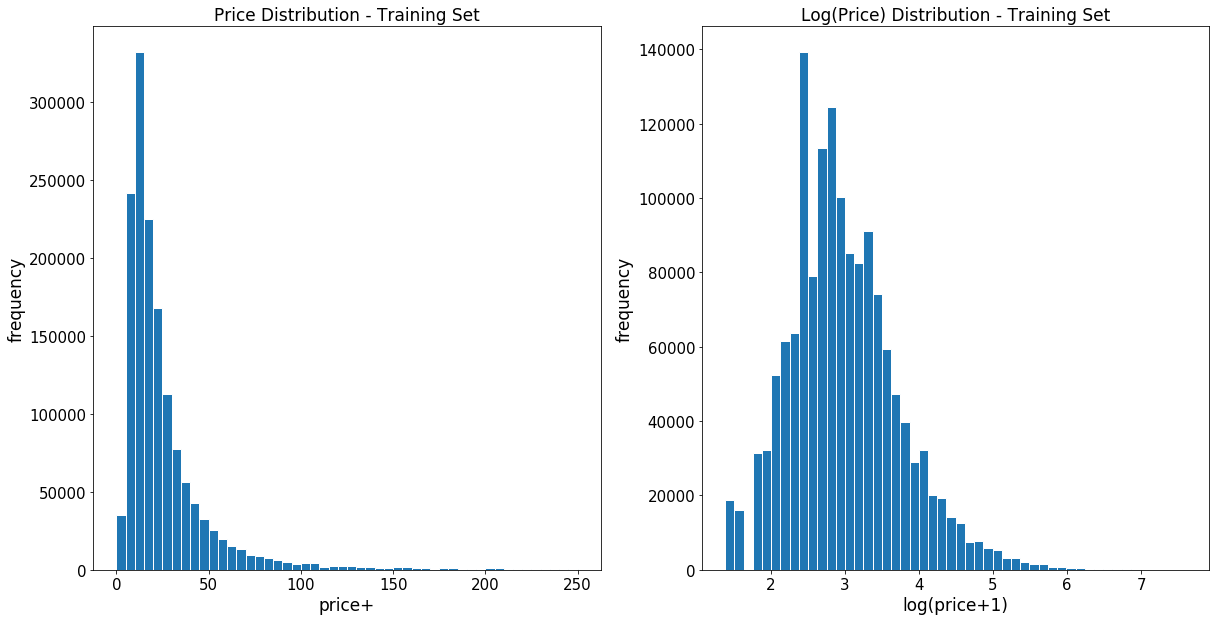

In [21]:
plt.subplot(1, 2, 1)
(df_train['price']).plot.hist(bins=50, figsize=(30,20), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(df_train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

In [22]:
df_train.shipping.value_counts()/len(df_train)

0    0.552674
1    0.447326
Name: shipping, dtype: float64

## **Shipping:**

In [23]:
free_shipping = df_train[df_train['shipping']==1]
print('%0.2f%% percent of the product with free shipping' % (100 * len(free_shipping)/len(df_train)))


44.73% percent of the product with free shipping


In [24]:
def price_double_hist(price1, price2, label1='price 1', label2='price 2',
                      bins=100, r=[0,200], title='Double Price Distribution', **argv):
    plt.figure(figsize=(20, 15))
    plt.hist(price1, bins=bins, range=r, label=label1, **argv)
    plt.hist(price2, bins=bins, range=r, label=label2, **argv)
    plt.title(title, fontsize=15)
    plt.xlabel('Price', fontsize=15)
    plt.ylabel('Samples', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.show()

C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


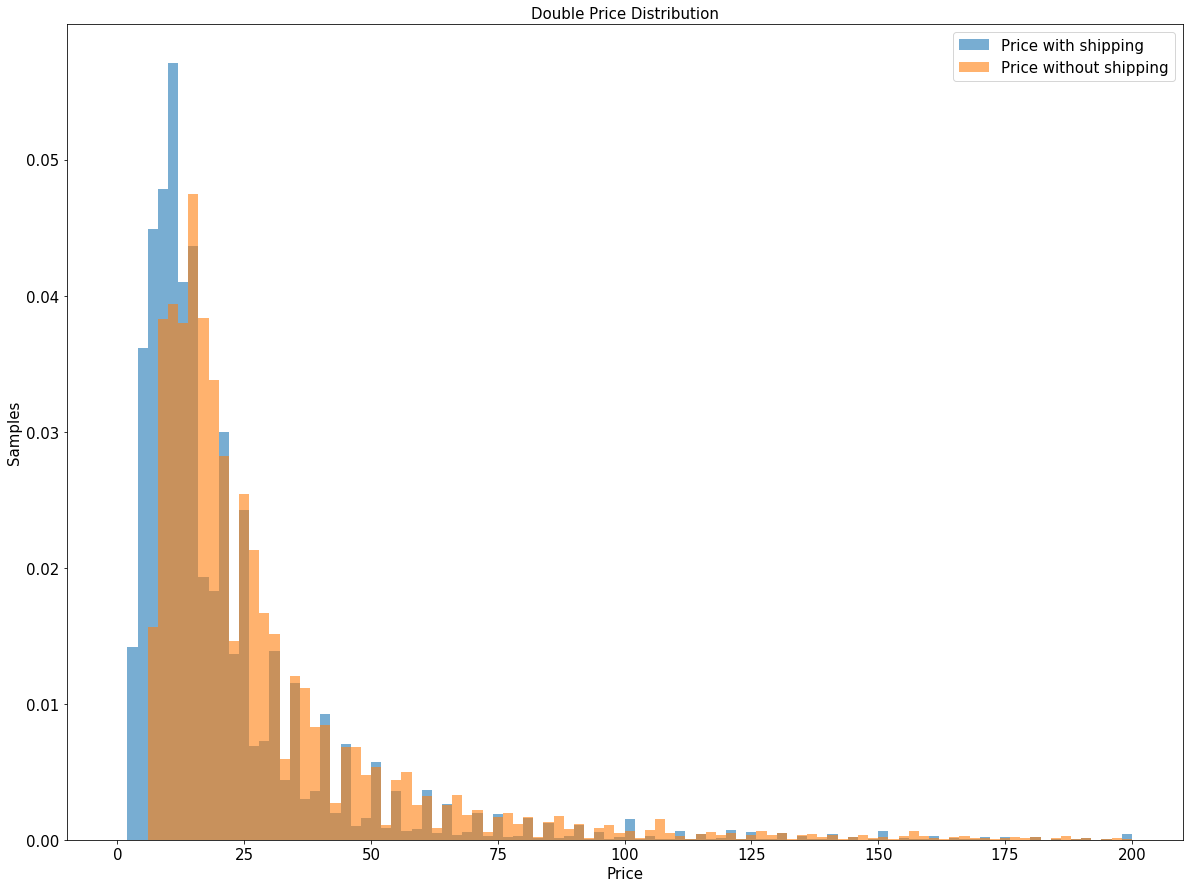

In [25]:
price_double_hist(price1=df_train[df_train['shipping']==1]['price'], 
                  price2=df_train[df_train['shipping']==0]['price'],
                  label1='Price with shipping',
                  label2='Price without shipping',
                  normed=True, alpha=0.6)

### Lower price item got shipping free.

## Text Preprocessing:

In [26]:
# changing the values for the description as missing:
df_train['item_description'] == 'No description yet'

0           True
1          False
2          False
3          False
4          False
5          False
6          False
7          False
8          False
9          False
10         False
11         False
12         False
13          True
14         False
15         False
16         False
17         False
18         False
19         False
20         False
21         False
22         False
23         False
24         False
25         False
26         False
27         False
28         False
29         False
           ...  
1482505    False
1482506    False
1482507    False
1482508    False
1482509    False
1482510    False
1482511    False
1482512    False
1482513    False
1482514    False
1482515    False
1482516    False
1482517    False
1482518    False
1482519    False
1482520    False
1482521    False
1482522    False
1482523    False
1482524    False
1482525    False
1482526    False
1482527    False
1482528    False
1482529    False
1482530    False
1482531    False
1482532    Fal

In [27]:
def tokenizer(text):
    if text:
        result = re.findall('[a-z]{2,}', text.lower())
    else:
        result = []
    return result

In [28]:
df_train['item_description'].fillna(value='Missing', inplace=True)
X = (df_train['name'] + ' ' + df_train['item_description']).values
y = np.log1p(df_train['price'].values)

# Splitting the dataset.
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=seed)

In [29]:
X

array(['MLB Cincinnati Reds T Shirt Size XL No description yet',
       'Razer BlackWidow Chroma Keyboard This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.',
       'AVA-VIV Blouse Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!',
       ...,
       '21 day fix containers and eating plan Used once or twice, still in great shape.',
       'World markets lanterns There is 2 of each one that you see! So 2 red 2 orange and 2 of the big red and orange ones! They are from world market!',
       'Brand new lux de ville wallet New with tag, red with sparkle. Firm price, no free shipping.'],
      dtype=object)

In [30]:
y


array([2.39789527, 3.97029191, 2.39789527, ..., 2.56494936, 3.8286414 ,
       3.13549422])

In [31]:
# using tf-idf converting the text into vector

vect = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')
X_train_vect = vect.fit_transform(X_train)


In [32]:
X_train_vect

<1037162x136353 sparse matrix of type '<class 'numpy.float64'>'
	with 16613286 stored elements in Compressed Sparse Row format>

In [33]:
# I was using a LinearRegression previously, but with the wider vocab it's too slow. 
# Let's use the SGDRegressor with ordinary least squares.
# Also, using mean squared error as the eval metric, since negative values crash mean squared log error.

model = SGDRegressor(loss='squared_loss', penalty='l2', random_state=seed, max_iter=5)
params = {'penalty':['none','l2','l1'],
          'alpha':[1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1]}
gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring='neg_mean_squared_error',
                  n_jobs=1,
                  cv=5,
                  verbose=3)
gs.fit(X_train_vect, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] alpha=0.0001, penalty=none ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=none, score=-0.40682647567111546, total=   2.1s
[CV] alpha=0.0001, penalty=none ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=none, score=-0.40344738584371964, total=   2.4s
[CV] alpha=0.0001, penalty=none ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s
C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=none, score=-0.4056701214577155, total=   2.3s
[CV] alpha=0.0001, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=none, score=-0.4078712000506386, total=   2.6s
[CV] alpha=0.0001, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=none, score=-0.40372717260191987, total=   3.1s
[CV] alpha=0.0001, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=l2, score=-0.40679039279769297, total=   3.3s
[CV] alpha=0.0001, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=l2, score=-0.4034733235635451, total=   3.3s
[CV] alpha=0.0001, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=l2, score=-0.405630228305653, total=   3.1s
[CV] alpha=0.0001, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=l2, score=-0.40791562625891603, total=   2.9s
[CV] alpha=0.0001, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=l2, score=-0.40371073894075293, total=   2.5s
[CV] alpha=0.0001, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=l1, score=-0.42413613351594104, total=   2.7s
[CV] alpha=0.0001, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=l1, score=-0.42079601607003864, total=   2.8s
[CV] alpha=0.0001, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=l1, score=-0.4229616054735334, total=   2.6s
[CV] alpha=0.0001, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=l1, score=-0.4254945518115486, total=   2.7s
[CV] alpha=0.0001, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0001, penalty=l1, score=-0.42080331141385313, total=   2.7s
[CV] alpha=0.0002, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=none, score=-0.40682647567111546, total=   1.9s
[CV] alpha=0.0002, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=none, score=-0.40344738584371964, total=   1.9s
[CV] alpha=0.0002, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=none, score=-0.4056701214577155, total=   2.0s
[CV] alpha=0.0002, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=none, score=-0.4078712000506386, total=   2.0s
[CV] alpha=0.0002, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=none, score=-0.40372717260191987, total=   1.9s
[CV] alpha=0.0002, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=l2, score=-0.40728914275513156, total=   1.9s
[CV] alpha=0.0002, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=l2, score=-0.404035215383276, total=   2.0s
[CV] alpha=0.0002, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=l2, score=-0.40612954338282375, total=   1.9s
[CV] alpha=0.0002, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=l2, score=-0.40849112131734494, total=   1.9s
[CV] alpha=0.0002, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=l2, score=-0.4042269725016847, total=   1.9s
[CV] alpha=0.0002, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=l1, score=-0.4354550214832102, total=   3.0s
[CV] alpha=0.0002, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=l1, score=-0.4322046524797213, total=   3.0s
[CV] alpha=0.0002, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=l1, score=-0.4343977591021835, total=   2.8s
[CV] alpha=0.0002, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=l1, score=-0.4371051956155033, total=   3.1s
[CV] alpha=0.0002, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0002, penalty=l1, score=-0.43214445767419984, total=   2.8s
[CV] alpha=0.0005, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=none, score=-0.40682647567111546, total=   2.4s
[CV] alpha=0.0005, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=none, score=-0.40344738584371964, total=   1.9s
[CV] alpha=0.0005, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=none, score=-0.4056701214577155, total=   2.0s
[CV] alpha=0.0005, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=none, score=-0.4078712000506386, total=   2.0s
[CV] alpha=0.0005, penalty=none ......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=none, score=-0.40372717260191987, total=   2.0s
[CV] alpha=0.0005, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=l2, score=-0.4109997334327395, total=   2.1s
[CV] alpha=0.0005, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=l2, score=-0.40793622407991537, total=   2.0s
[CV] alpha=0.0005, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=l2, score=-0.4098628137339489, total=   2.1s
[CV] alpha=0.0005, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=l2, score=-0.4124109471494952, total=   2.0s
[CV] alpha=0.0005, penalty=l2 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=l2, score=-0.40797947740821805, total=   2.0s
[CV] alpha=0.0005, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=l1, score=-0.4615632921295246, total=   2.8s
[CV] alpha=0.0005, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=l1, score=-0.4578912945348592, total=   2.7s
[CV] alpha=0.0005, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=l1, score=-0.46060307461105543, total=   2.7s
[CV] alpha=0.0005, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=l1, score=-0.46367275017204646, total=   2.7s
[CV] alpha=0.0005, penalty=l1 ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.0005, penalty=l1, score=-0.45858911426294674, total=   2.7s
[CV] alpha=0.001, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=none, score=-0.40682647567111546, total=   1.9s
[CV] alpha=0.001, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=none, score=-0.40344738584371964, total=   1.9s
[CV] alpha=0.001, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=none, score=-0.4056701214577155, total=   2.0s
[CV] alpha=0.001, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=none, score=-0.4078712000506386, total=   2.0s
[CV] alpha=0.001, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=none, score=-0.40372717260191987, total=   2.0s
[CV] alpha=0.001, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=l2, score=-0.4208075418876127, total=   2.0s
[CV] alpha=0.001, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=l2, score=-0.41804435558199377, total=   2.0s
[CV] alpha=0.001, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=l2, score=-0.41975359172220017, total=   1.9s
[CV] alpha=0.001, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=l2, score=-0.42250652572195513, total=   2.0s
[CV] alpha=0.001, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=l2, score=-0.4178329153611878, total=   2.1s
[CV] alpha=0.001, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=l1, score=-0.4935111840626581, total=   2.9s
[CV] alpha=0.001, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=l1, score=-0.4902338756135875, total=   2.6s
[CV] alpha=0.001, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] . alpha=0.001, penalty=l1, score=-0.49259726655118, total=   2.6s
[CV] alpha=0.001, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=l1, score=-0.49606119082692707, total=   2.7s
[CV] alpha=0.001, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.001, penalty=l1, score=-0.4911498968069679, total=   2.8s
[CV] alpha=0.002, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=none, score=-0.40682647567111546, total=   2.0s
[CV] alpha=0.002, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=none, score=-0.40344738584371964, total=   1.9s
[CV] alpha=0.002, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=none, score=-0.4056701214577155, total=   1.9s
[CV] alpha=0.002, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=none, score=-0.4078712000506386, total=   1.9s
[CV] alpha=0.002, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=none, score=-0.40372717260191987, total=   1.9s
[CV] alpha=0.002, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=l2, score=-0.4418435511085123, total=   1.9s
[CV] alpha=0.002, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=l2, score=-0.43956640458379176, total=   2.0s
[CV] alpha=0.002, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=l2, score=-0.44101193543574563, total=   1.9s
[CV] alpha=0.002, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=l2, score=-0.44394777195267165, total=   1.9s
[CV] alpha=0.002, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=l2, score=-0.4389163608272913, total=   1.9s
[CV] alpha=0.002, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=l1, score=-0.5220578961578265, total=   2.5s
[CV] alpha=0.002, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=l1, score=-0.5203428468612666, total=   2.6s
[CV] alpha=0.002, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=l1, score=-0.5218140384354888, total=   2.9s
[CV] alpha=0.002, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=l1, score=-0.5256567392509431, total=   3.0s
[CV] alpha=0.002, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.002, penalty=l1, score=-0.5198023419392029, total=   2.7s
[CV] alpha=0.005, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=none, score=-0.40682647567111546, total=   2.1s
[CV] alpha=0.005, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=none, score=-0.40344738584371964, total=   2.0s
[CV] alpha=0.005, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=none, score=-0.4056701214577155, total=   2.2s
[CV] alpha=0.005, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=none, score=-0.4078712000506386, total=   2.0s
[CV] alpha=0.005, penalty=none .......................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=none, score=-0.40372717260191987, total=   2.1s
[CV] alpha=0.005, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=l2, score=-0.4822567407356618, total=   2.3s
[CV] alpha=0.005, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=l2, score=-0.4807284782718777, total=   2.0s
[CV] alpha=0.005, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=l2, score=-0.48192139558596947, total=   2.0s
[CV] alpha=0.005, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=l2, score=-0.48491033849925236, total=   2.1s
[CV] alpha=0.005, penalty=l2 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=l2, score=-0.47939792302503226, total=   2.1s
[CV] alpha=0.005, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=l1, score=-0.5526417234683443, total=   2.9s
[CV] alpha=0.005, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=l1, score=-0.5520083115416141, total=   2.5s
[CV] alpha=0.005, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=l1, score=-0.5530448877653169, total=   2.5s
[CV] alpha=0.005, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=l1, score=-0.5560557219362164, total=   2.4s
[CV] alpha=0.005, penalty=l1 .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.005, penalty=l1, score=-0.5499706670871001, total=   2.4s
[CV] alpha=0.01, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=none, score=-0.40682647567111546, total=   1.9s
[CV] alpha=0.01, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=none, score=-0.40344738584371964, total=   1.9s
[CV] alpha=0.01, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=none, score=-0.4056701214577155, total=   1.9s
[CV] alpha=0.01, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=none, score=-0.4078712000506386, total=   1.9s
[CV] alpha=0.01, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=none, score=-0.40372717260191987, total=   1.9s
[CV] alpha=0.01, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=l2, score=-0.5099402739180539, total=   1.9s
[CV] alpha=0.01, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=l2, score=-0.5088025108407198, total=   2.3s
[CV] alpha=0.01, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=l2, score=-0.5099097410548038, total=   3.2s
[CV] alpha=0.01, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=l2, score=-0.5128763592361559, total=   2.8s
[CV] alpha=0.01, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=l2, score=-0.5071576520537459, total=   2.5s
[CV] alpha=0.01, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=l1, score=-0.5564530597405362, total=   2.6s
[CV] alpha=0.01, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=l1, score=-0.5558079753227396, total=   2.8s
[CV] alpha=0.01, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=l1, score=-0.5569077914002427, total=   2.5s
[CV] alpha=0.01, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=l1, score=-0.5598820379109621, total=   2.5s
[CV] alpha=0.01, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.01, penalty=l1, score=-0.5538006742990881, total=   2.5s
[CV] alpha=0.02, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=none, score=-0.40682647567111546, total=   1.9s
[CV] alpha=0.02, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=none, score=-0.40344738584371964, total=   1.9s
[CV] alpha=0.02, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=none, score=-0.4056701214577155, total=   1.9s
[CV] alpha=0.02, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=none, score=-0.4078712000506386, total=   1.9s
[CV] alpha=0.02, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=none, score=-0.40372717260191987, total=   2.2s
[CV] alpha=0.02, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=l2, score=-0.5295264062369036, total=   1.9s
[CV] alpha=0.02, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=l2, score=-0.5285993951069193, total=   2.1s
[CV] alpha=0.02, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=l2, score=-0.5296730490787993, total=   2.2s
[CV] alpha=0.02, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=l2, score=-0.5326389950846299, total=   2.0s
[CV] alpha=0.02, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] . alpha=0.02, penalty=l2, score=-0.526812964043817, total=   2.0s
[CV] alpha=0.02, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=l1, score=-0.5564529436049991, total=   2.5s
[CV] alpha=0.02, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=l1, score=-0.5558078792086449, total=   2.5s
[CV] alpha=0.02, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=l1, score=-0.5569080790667883, total=   3.7s
[CV] alpha=0.02, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] . alpha=0.02, penalty=l1, score=-0.559881661563049, total=   2.8s
[CV] alpha=0.02, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.02, penalty=l1, score=-0.5538006986167251, total=   2.8s
[CV] alpha=0.05, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=none, score=-0.40682647567111546, total=   2.2s
[CV] alpha=0.05, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=none, score=-0.40344738584371964, total=   2.1s
[CV] alpha=0.05, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=none, score=-0.4056701214577155, total=   2.1s
[CV] alpha=0.05, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=none, score=-0.4078712000506386, total=   2.2s
[CV] alpha=0.05, penalty=none ........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=none, score=-0.40372717260191987, total=   2.0s
[CV] alpha=0.05, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=l2, score=-0.5444355183798593, total=   2.0s
[CV] alpha=0.05, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=l2, score=-0.5436454755602892, total=   2.0s
[CV] alpha=0.05, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=l2, score=-0.5447255409602305, total=   2.0s
[CV] alpha=0.05, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=l2, score=-0.5476927986463506, total=   2.3s
[CV] alpha=0.05, penalty=l2 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=l2, score=-0.5417660711443413, total=   2.2s
[CV] alpha=0.05, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=l1, score=-0.5564529286899074, total=   2.4s
[CV] alpha=0.05, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=l1, score=-0.5558078669479383, total=   2.6s
[CV] alpha=0.05, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=l1, score=-0.5569081215972177, total=   2.4s
[CV] alpha=0.05, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=l1, score=-0.5598816100085356, total=   2.7s
[CV] alpha=0.05, penalty=l1 ..........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.05, penalty=l1, score=-0.5538007035875575, total=   2.6s
[CV] alpha=0.1, penalty=none .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.1, penalty=none, score=-0.40682647567111546, total=   2.1s
[CV] alpha=0.1, penalty=none .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.1, penalty=none, score=-0.40344738584371964, total=   2.0s
[CV] alpha=0.1, penalty=none .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.1, penalty=none, score=-0.4056701214577155, total=   2.1s
[CV] alpha=0.1, penalty=none .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.1, penalty=none, score=-0.4078712000506386, total=   1.9s
[CV] alpha=0.1, penalty=none .........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV]  alpha=0.1, penalty=none, score=-0.40372717260191987, total=   2.0s
[CV] alpha=0.1, penalty=l2 ...........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] . alpha=0.1, penalty=l2, score=-0.5501848458105942, total=   2.1s
[CV] alpha=0.1, penalty=l2 ...........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] .. alpha=0.1, penalty=l2, score=-0.549452687717651, total=   1.9s
[CV] alpha=0.1, penalty=l2 ...........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] . alpha=0.1, penalty=l2, score=-0.5505335529251485, total=   2.1s
[CV] alpha=0.1, penalty=l2 ...........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] .. alpha=0.1, penalty=l2, score=-0.553504859994099, total=   2.0s
[CV] alpha=0.1, penalty=l2 ...........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] . alpha=0.1, penalty=l2, score=-0.5475193962956705, total=   2.1s
[CV] alpha=0.1, penalty=l1 ...........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] . alpha=0.1, penalty=l1, score=-0.5564529280704872, total=   2.5s
[CV] alpha=0.1, penalty=l1 ...........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] . alpha=0.1, penalty=l1, score=-0.5558078664554573, total=   2.7s
[CV] alpha=0.1, penalty=l1 ...........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] .. alpha=0.1, penalty=l1, score=-0.556908123313564, total=   2.5s
[CV] alpha=0.1, penalty=l1 ...........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] . alpha=0.1, penalty=l1, score=-0.5598816079788275, total=   2.9s
[CV] alpha=0.1, penalty=l1 ...........................................


C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


[CV] . alpha=0.1, penalty=l1, score=-0.5538007037900725, total=   2.5s


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  6.3min finished
C:\Users\selvm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=5,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=101, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'penalty': ['none', 'l2', 'l1'], 'alpha': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=3)

In [34]:
model = gs.best_estimator_
print(gs.best_params_)
print(gs.best_score_)

{'alpha': 0.0001, 'penalty': 'l2'}
-0.40550406125557686


In [35]:
pipe = Pipeline([('vect',vect),('model',model)])
y_pred = pipe.predict(X_test)


In [36]:
print(np.sqrt(mean_squared_log_error(np.exp(y_test)-1, np.exp(y_pred)-1)))

0.6240620344403682


In [37]:
df_test = pd.read_csv('test_.tsv', sep='\t')
df_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [38]:
df_test['item_description'].fillna('Missing', inplace=True)
df_test['price'] = np.exp(pipe.predict((df_test['name'] + ' ' + df_test['item_description']).values))-1
df_test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,price
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,12.447805
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",10.736194
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,32.479483
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,13.387018
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,12.004125


In [39]:
df_test[['test_id','price']].to_csv('mercari_output.csv', index=False)